# GADM process layers
Our clients want to use their country context, so we have to edit our GADM layer and make these new country context fit into GADM layer
Here is the process:
- Locate the polygon we want to substitute in the GADM layer
- Delete it from the layer
- from the new polygon, get coordinate possitions
- select the surrounding countries
- snap the surrounding countries to the polygon

- import layers:
    * GADM layer
    * Client country 

- Main idea: https://gis.stackexchange.com/questions/245064/snapping-multiple-nodes-of-a-polygon-to-the-nodes-of-a-line
- Create a linestring from the polygon: https://gis.stackexchange.com/questions/290756/transforming-a-polygon-to-a-linestring
- Snap Geopandas: https://gis.stackexchange.com/questions/290092/how-to-do-snapping-in-geopandas
- https://gis.stackexchange.com/questions/203058/why-is-shapelys-snapping-geo-snaps-not-working-as-expected

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, Point, box
from shapely.ops import snap
from shapely import wkt
import os
from sys import path
import matplotlib.pyplot as plt


In [2]:
"""Create dataframes of the import data"""
os.chdir(r"C:\Users\ruben.crespo\Documents\03_tests\administrative_units\09_norway_case")

client_country_name = "NOR"

gadm_path = r"C:\Users\ruben.crespo\Documents\03_tests\administrative_units\09_norway_case\administrative_units_un_gadm_level0_can_rus_3.shp"
client_path = r"C:/Users/ruben.crespo/Documents/03_tests/administrative_units/09_norway_case/kommuner_2022_wgs84_navn.shp"
gadm_gdf = gpd.read_file(gadm_path)
client_gdf = gpd.read_file(client_path)

In [3]:
# https://stackoverflow.com/questions/60780959/how-to-filter-a-geodataframe-by-geometry-type
"""Here we check the geometry type and the number of polygons 6f the import file"""
geometry_dic = {}
geometry_type = client_gdf.geom_type.unique().tolist() #we create a list of unique geometries
if len(geometry_type) > 0: #if there are more than one type we list them
    for i in geometry_type:
        geometry_gdf = client_gdf[client_gdf.geom_type == i] #new df with the geometry
        geometry_rows = geometry_gdf.shape[0] #number of elements
        geometry_dic.update({i:geometry_rows}) #add to dic
        
        
print(geometry_dic)

# geometry_str = ''.join(geometry_gdf.geom_type.unique().tolist()) #transform the list to string


{'Polygon': 363}


0    Polygon
dtype: object


<AxesSubplot:>

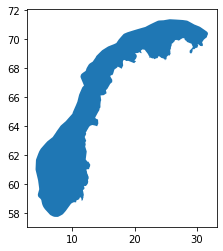

In [4]:
"""if we have a multipolygon (lots of polygons), we dissolve it"""
client_area_gdf = client_gdf.dissolve()
# check again its geometry
print(str(client_area_gdf.geom_type))
client_area_gdf.plot()
# client_dissolve.head()

In [5]:
# https://gis.stackexchange.com/questions/281652/finding-all-neighbors-using-geopandas
"""Extract from GADM the surrounding countries of the one we want to edit"""
for row_index, row in gadm_gdf.iterrows():
    if row[0] == client_country_name: #the country we are importing
        neightbour_countries_gdf = gadm_gdf[gadm_gdf.geometry.touches(row['geometry'])]
    else:
        pass
# neightbour_countries_gdf = neightbour_countries_gdf.reset_index(drop=False) #restart the index MAYBE WE DONT HAVE TO DO THAT

# ax = neightbour_countries_gdf.plot(cmap='jet', markersize=1, alpha=0.5)
# ax.set_xlim([4.087524332196379, 31.761592895114386])
# ax.set_ylim([57.75900528198801, 71.38487875561317])
neightbour_countries_gdf.head()


,CID,Shape_Leng,Shape_Area,Country_n,GID,GID_list,GID_n,geometry
61,FIN,231.567531,62.931585,Finland,FIN,FIN,Finland,"MULTIPOLYGON (((22.49806 59.72403, 22.49806 59..."
182,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55..."
377,RUS,70.305320,30.520940,Russia,RUS45,"RUS1,RUS...,RUS84",Murmansk,"MULTIPOLYGON (((40.53593 67.83385, 40.53750 67..."


In [6]:
"""Get the country list, and start doing a difference with both main and surrounding countries""" 
countries = []
for row_index, country in neightbour_countries_gdf.iterrows():
    countries.append(country[0])
countries

['FIN', 'SWE', 'RUS']

In [7]:
"""We create an empty GeoDataFrame to append inside the countries that are finished"""
finished_countries_gs = gpd.GeoSeries()#.reindex_like(new_neightbour_countries_gs)
finished_countries_gs.crs = "EPSG:4326"

c:\Users\ruben.crespo\Anaconda3\envs\geoprocessing\lib\site-packages\geopandas\geoseries.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)


<AxesSubplot:>

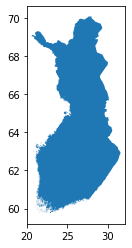

In [8]:

"""Get the country"""
#This sould iterate for every country, but as we are testing, we are only doing one
for i in countries:
    if i == "FIN": #FIN SWE RUS
        country_gdf = neightbour_countries_gdf.loc[(neightbour_countries_gdf["CID"] == "FIN")] #here goes i
    else:
        pass
country_gdf.plot()

<AxesSubplot:>

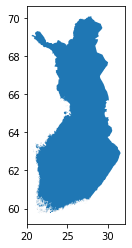

In [9]:
"""Difference of the country and the client"""
new_country_gs = country_gdf.difference(client_area_gdf, align= False)
new_country_gs.plot() #country_difference_gs

In [10]:
finished_countries_gs

GeoSeries([], dtype: geometry)

In [ ]:
client_area_gs.plot()

In [15]:
"""Union the client country with the possible fixed countries"""
"""BEWARE: Union works with index, to make it work, it has to be one element per index value"""
if len(finished_countries_gs.index) == 0:
    pass
else:
    #Dissolve first, only works with gdf
    finished_countries_gdf = gpd.GeoDataFrame(geometry=finished_countries_gs)
    
    finished_countries_gdf = finished_countries_gdf.dissolve()
    client_area_gs = client_area_gdf.geometry.union(finished_countries_gdf, align=False)
    client_area_gs.plot()

<AxesSubplot:>

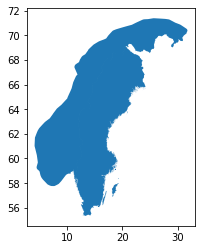

In [17]:
"""Union both countries  (+ possible fixed countries)"""
# client_dissolve_gs = gpd.GeoSeries(client_area_gdf['geometry']) #transform the data to geoseries
country_union_gs = new_country_gs.union(client_area_gdf.geometry, align=False)
country_union_gs.plot()

<AxesSubplot:>

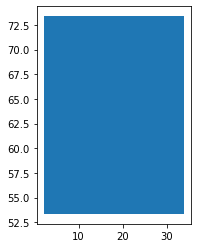

In [24]:
"""We generate the bbox to create a megapolygon with the bbox of the union"""
offset = 1 #be careful with the projection. If meters = 100, if degrees = 1
tolerance = 1
bbox_df = country_union_gs.bounds + [-offset, -offset, offset, offset]
bbox_df['minx'] = bbox_df['minx'].sub(tolerance) # opearte in single columnn
bbox_df['miny'] = bbox_df['miny'].sub(tolerance)
bbox_df['maxx'] = bbox_df['maxx'].add(tolerance)
bbox_df['maxy'] = bbox_df['maxy'].add(tolerance)

b = [box(l, b, r, t) for l, b, r, t in zip(bbox_df.minx, bbox_df.miny, bbox_df.maxx, bbox_df.maxy)] #this is the geometry
bbox_gdf = gpd.GeoDataFrame(bbox_df, geometry=b)
bbox_gdf.crs = "EPSG:4326"
bbox_gdf.plot() #pandas dataframe 

In [ ]:
"""This new approach, will do the difference with the bbox and the union countries, we are having problems here"""
"""Do a difference of the both with the country"""
country_union_gdf = gpd.GeoDataFrame(geometry=country_union_gs)
country_union_gdf = country_union_gdf.difference(bbox_gdf.geometry, align= False)
country_union_gdf.plot()

<AxesSubplot:>

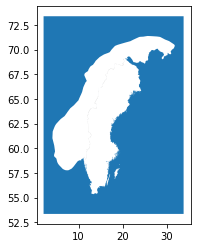

In [19]:
"""Do a difference with both"""

bbox_gdf = bbox_gdf.difference(country_union_gs, align= False)
bbox_gdf.plot()

In [20]:

"""Pass to gdf and explode the multiplygon"""
bbox_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bbox_gdf)) 
bbox_gdf = bbox_gdf.explode(index_parts=False)
bbox_gdf.head()

geometry
182 0  POLYGON ((2.08752 53.33625, 2.08752 73.38488, ...
    1  POLYGON ((11.24509 59.09264, 11.24613 59.09290...
    2  POLYGON ((11.29041 59.10025, 11.29646 59.10323...
    3  POLYGON ((11.30106 59.10550, 11.30250 59.10621...
    4  POLYGON ((11.32605 59.11172, 11.32624 59.11176...

In [21]:
"""Calculate the area and sort by size, then, delete the first row as it is the biggest one"""
bbox_gdf['area'] = bbox_gdf.area
bbox_gdf.sort_values(by=['area'], ascending=False) #sort the values to size
bbox_gdf = bbox_gdf.iloc[1: , :] #extract the first polygon, which is the biggest one
bbox_gdf.head()


C:\Users\ruben.crespo\AppData\Local\Temp\ipykernel_19568\2178125016.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox_gdf['area'] = bbox_gdf.area


geometry      area
182 1  POLYGON ((11.24509 59.09264, 11.24613 59.09290...  0.000009
    2  POLYGON ((11.29041 59.10025, 11.29646 59.10323...  0.000009
    3  POLYGON ((11.30106 59.10550, 11.30250 59.10621...  0.000016
    4  POLYGON ((11.32605 59.11172, 11.32624 59.11176...  0.000020
    5  POLYGON ((11.34757 59.11053, 11.35049 59.10884...  0.000002

<AxesSubplot:>

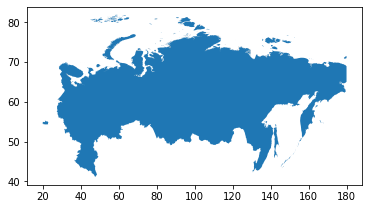

In [79]:
"""Dissolve the small polygons and union with the country of sweeden"""
bbox_gdf = bbox_gdf.dissolve()
new_country_gs = new_country_gs.union(bbox_gdf['geometry'], align=False)
new_country_gs.plot()

In [80]:
"""Append new country to the finished gs list"""
finished_countries_gs = finished_countries_gs.append(new_country_gs)

c:\Users\ruben.crespo\Anaconda3\envs\geoprocessing\lib\site-packages\geopandas\geoseries.py:551: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = getattr(super(GeoSeries, self), mtd)(*args, **kwargs)


In [84]:
"""Update the neighbours gdf with the gs"""
neightbour_countries_gdf = neightbour_countries_gdf.set_geometry(finished_countries_gs)
neightbour_countries_gdf

,CID,Shape_Leng,Shape_Area,Country_n,GID,GID_list,GID_n,geometry
61,FIN,231.567531,62.931585,Finland,FIN,FIN,Finland,"MULTIPOLYGON (((22.49917 59.72430, 22.49917 59..."
182,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94195 55.46292, 12.94195 55..."
317,RUS,NaN,NaN,Russian Federation,RUS1,"RUS1,RUS2",Russian Federation,"MULTIPOLYGON (((33.06250 66.57917, 33.06042 66..."


In [85]:
"""Do the exportation to see wtf is happening"""
neightbour_countries_gdf.to_file('neighbour_fixed.shp', driver="ESRI Shapefile")

c:\Users\ruben.crespo\Anaconda3\envs\geoprocessing\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
"""Create a gs with the new country and the rest of the neightbour country geometries"""

#we do a copy, which will be updated

new_neightbour_countries_gs = new_country_gs

for row_index, row in neightbour_countries_gdf.iterrows(): #row is a pandas series
     #row_index 0,1,2
     row_gs = gpd.GeoSeries(row['geometry'], index=[row_index]) #transform to Geoseries, adds the index VERY IMPORTANT if not, everything will be 0

     row_gs.crs =  "EPSG:4326" #transform to correct projection
     if row_index == new_country_gs.index: #we want to slip that part
          pass
     else:
          new_neightbour_countries_gs = new_neightbour_countries_gs.append(row_gs, ignore_index=False) #the "x = x" must be the same so we accumulate the values

new_neightbour_countries_gs.sort_index() #Here we sort the index descending

"""Update the neighbours gdf with the gs"""
neightbour_countries_gdf = neightbour_countries_gdf.set_geometry(new_neightbour_countries_gs)
neightbour_countries_gdf

# OTHER STUFF I HAVE BEEN TESTING

# Here is an idea
- Dissolve all the touching countries into one.
- Do the difference with the clien_country

<AxesSubplot:>

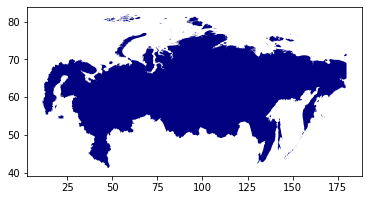

In [10]:
"""Dissolve neightbour countries"""
neightbour_dissolve_gdf = neightbour_countries_gdf.dissolve()
# neightbour_dissolve_gdf.plot(cmap='jet')

In [42]:
"""Difference of norway and rest so we define the external limitation"""
neightbour_difference_gs = neightbour_dissolve_gdf.difference(client_dissolve_gdf, align= False)
# country_difference_gs.plot(cmap='jet')
"""Difference of norway and sweeden"""
country_difference_gs = country_gdf.difference(client_dissolve_gdf, align= False)
# country_difference_gs.plot()

In [43]:
"""Union / Dissolve everything, the neightbourhgtour countries and the client country"""
client_dissolve_gs = gpd.GeoSeries(client_dissolve_gdf['geometry']) #transform the data to geoseries
country_neightbour_union_gs = neightbour_difference_gs.union(client_dissolve_gs, align=False)
# country_union_gs.plot()

In [ ]:
"""We generate the bbox to create a megapolygon with the bbox of the whole union"""
offset = 1 #be careful with the projection. If meters = 100, if degrees = 1
tolerance = 1
bbox_df = country_neightbour_union_gs.bounds + [-offset, -offset, offset, offset]

bbox_df['minx'] = bbox_df['minx'].sub(tolerance) # opearte in single columnn
bbox_df['miny'] = bbox_df['miny'].sub(tolerance)
bbox_df['maxx'] = bbox_df['maxx'].add(tolerance)
bbox_df['maxy'] = bbox_df['maxy'].add(tolerance)

b = [box(l, b, r, t) for l, b, r, t in zip(bbox_df.minx, bbox_df.miny, bbox_df.maxx, bbox_df.maxy)] #this is the geometry
bbox_gdf = gpd.GeoDataFrame(bbox_df, geometry=b) #bbox dataframe to geodataframe 
bbox_gdf.crs = "EPSG:4326" #set the crs

"""Do a difference with both"""
bbox_gdf = bbox_gdf.difference(country_union_gs, align= False)


"""Pass to gdf and explode the multiplygon"""
bbox_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bbox_gdf))
#important documentation from explode: https://gis.stackexchange.com/questions/384513/exploding-column-in-geopandas
bbox_gdf = bbox_gdf.explode(ignore_index=False, index_parts=False) #the index_parts does not work, it creates a multiindex
# print(bbox_gdf.reset_index())
bbox_gdf = bbox_gdf.reset_index(level=[0,1]) #to undo the multidindex

#Here we loose the original index

"""Calculate the area and sort by size, then, delete the first row as it is the biggest one"""
# bbox_gs = gpd.GeoSeries(bbox_gdf['geometry'])
# bbox_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bbox_gs))
bbox_gdf['area'] = bbox_gdf.area



bbox_gdf.sort_values(by=['area'], ascending=False) #sort the values to size
bbox_gdf = bbox_gdf.iloc[1: , :] #extract the first polygon, which is the biggest one

In [78]:
bbox_gdf.head()

,level_0,level_1,geometry,area
1,0,1,"POLYGON ((27.74018 58.99980, 27.74021 58.99983...",1.599644e-07
2,0,2,"POLYGON ((28.06322 59.29858, 28.06309 59.29877...",1.732305e-06
3,0,3,"POLYGON ((28.06208 59.29820, 28.06206 59.29834...",4.277355e-07
4,0,4,"POLYGON ((11.24509 59.09264, 11.24613 59.09290...",8.744653e-06
5,0,5,"POLYGON ((11.29041 59.10025, 11.29646 59.10323...",8.598755e-06


<AxesSubplot:>

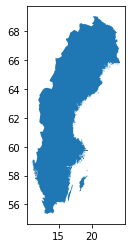

In [76]:
country_difference_gs.plot()

In [94]:
"""Do the exportation to see wtf is happening"""
country_difference_gs.to_file('country_difference_gs_1.shp', driver="ESRI Shapefile")

c:\Users\ruben.crespo\Anaconda3\envs\geoprocessing\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

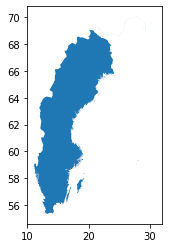

In [93]:
"""Dissolve the small polygons and union with the country of sweeden"""
bbox_gdf = bbox_gdf.dissolve()
# bbox_gs = gpd.GeoSeries(bbox_gdf['geometry']) #transform the data to geoseries
country_difference_gs = country_difference_gs.union(bbox_gdf.geometry, align=False)
country_difference_gs.plot()

In [92]:
"""Take all the small polygons that touch the country"""

test_gs = bbox_gdf['geometry'].sindex
# bbox_gs = gpd.GeoSeries(bbox_gdf['geometry'])
# country_gs = gpd.GeoSeries(country_gdf['geometry'])
# neightbour_countries_gdf = country_union_gs[country_union_gs.geometry.touches(row['geometry'])]

# boo = test_gs.touches(country_difference_gs)

# test_gdf = test_gdf[test_gdf.geometry.touches(country_difference_gs)]
#the elements touch the country, so we get the lsit of the elemetns and union to the main country


Problem is here: we can only touch one polygon, the bbox has a crs and the polygons, and the country_difference is correct

In [88]:
for i in boo:
    if i == True:
        print(i)
    else:
        pass

True


In [28]:
"""Take all the small polygons that touch the country"""
"""Union the small pieces of the bbox with the country we are working on"""
test_gdf = country_gdf

# bbox_gs = gpd.GeoSeries(bbox_gdf['geometry'])
# country_gs = gpd.GeoSeries(country_gdf['geometry'])

test_gs = test_gdf.geometry.append(bbox_gdf.geometry, ignore_index=False)
# tmp = tmp.join(neightbour_countries.reset_index(drop=True), on="polygon_i")



c:\Users\ruben.crespo\Anaconda3\envs\geoprocessing\lib\site-packages\geopandas\geoseries.py:551: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = getattr(super(GeoSeries, self), mtd)(*args, **kwargs)


In [29]:
test_gs.head()

182       MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...
(0, 1)    POLYGON ((27.74018 58.99980, 27.74021 58.99983...
(0, 2)    POLYGON ((28.06322 59.29858, 28.06309 59.29877...
(0, 3)    POLYGON ((28.06208 59.29820, 28.06206 59.29834...
(0, 4)    POLYGON ((11.24509 59.09264, 11.24613 59.09290...
dtype: geometry

In [ ]:
"""Dissolve the small polygons and union with the country of sweeden"""
bbox_gdf = bbox_gdf.dissolve()
bbox_gs = gpd.GeoSeries(bbox_gdf['geometry']) #transform the data to geoseries
country_difference_gs = country_difference_gs.union(bbox_gs, align=False)
country_difference_gs.plot()

In [6]:

"""Create the output file"""
res = client_dissolve
lines2_union = neightbour_countries.geometry.unary_union
res.geometry = res.geometry.apply(lambda x: snap(x, lines2_union, 10))
res.to_file('result.shp', driver="ESRI Shapefile")

In [ ]:
tmp_gdf = neightbour_countries.copy()
tmp_gdf['distance'] = tmp_gdf.distance(client_dissolve)
closest_geom = list(tmp_gdf.sort_values('distance')['geometry'])[1]

In [ ]:
#client_dissolve
for index, row in neightbour_countries.iterrows(): #country is the row that corresponds to the multipolygon of the country

    
   
    client_snapped = snap(row.loc['geometry'], client_dissolve.loc['geometry'] , 1)
    
    # print(row['geometry'], "\n")
    # tmp_gdf = s.copy()
    # tmp_gdf['distance'] = tmp_gdf.distance(row['geometry'])
    # closest_geom = list(tmp_gdf.sort_values('distance')['geometry'])[1]
    # # I took 1 because index 0 would be the row itself
    # snapped_geom = snap(row['geometry'], closest_geom, 0.5)
    # s.set_value(index, 'geometry', snapped_geom)
    # print(row, "\n")

In [18]:
for index, row in neightbour_countries.iterrows():
    tmp_gdf = neightbour_countries.copy()
    tmp_gdf['distance'] = tmp_gdf.distance(row['geometry'])
    closest_geom = list(tmp_gdf.sort_values('distance')['geometry'])[1]
    # I took 1 because index 0 would be the row itself
    snapped_geom = snap(row['geometry'], closest_geom, 1)
    neightbour_countries.loc[index, 'geometry'] = snapped_geom

C:\Users\ruben.crespo\AppData\Local\Temp\ipykernel_12528\3922114552.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tmp_gdf['distance'] = tmp_gdf.distance(row['geometry'])


In [ ]:
"""The snapping part (this in an example)"""
square = Polygon([(1,1), (2, 1), (2, 2), (1, 2), (1, 1)])
line = LineString([(0,0), (0.8, 0.8), (1.8, 0.95), (2.6, 0.5)])
result = snap(line, square, 0.5)
result.wkt

<class 'geopandas.geoseries.GeoSeries'>


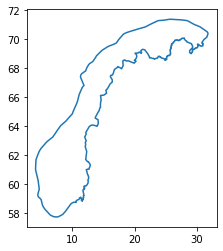

In [16]:
# Create a linestring from the polygon
if ''.join(client_dissolve.geom_type.unique().tolist()) == 'Polygon':
    client_linestring = client_dissolve.boundary
    print(type(client_linestring))
    client_linestring.plot()
else:
    print('check the geometry type again')
  

In [33]:
"""We creaate the GeoSeries Points from the Linestring"""

tuple_list = list(client_linestring.geometry[0].coords) #the elements inside are tuples
points = []

for x in tuple_list:
    y = Point(x)
    points.append(y)
    
# print(points)
d = {'geometry': points}
client_points = gpd.GeoDataFrame(d, crs="EPSG:4326") #this has to be a geodataframe, no geoseries
type(client_points)
client_points

,geometry
0,POINT (5.60118 58.28464)
1,POINT (5.59022 58.29056)
2,POINT (5.57860 58.29713)
3,POINT (5.57682 58.29820)
4,POINT (5.51954 58.33251)
...,...
19020,POINT (6.04436 58.07749)
19021,POINT (5.87175 58.15833)
19022,POINT (5.62302 58.27372)
19023,POINT (5.61046 58.27979)


In [8]:

"""from the gadm layer, remove the client country"""
client_country = (gadm_gdf['CID'] == 'NOR') #create a filter and use it the the dataframe
new_gadm_gdf = gadm_gdf.loc[gadm_gdf['CID'] != 'NOR'] #create dataframe out of the filter

In [14]:
"""View the result"""
neightbour_countries.head()

,CID,Shape_Leng,Shape_Area,Country_n,GID,GID_list,GID_n,geometry
61,FIN,231.567531,62.931585,Finland,FIN,FIN,Finland,"MULTIPOLYGON (((22.49806 59.72403, 22.49806 59..."
182,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55..."
317,RUS,NaN,NaN,Russian Federation,RUS1,"RUS1,RUS2",Russian Federation,"MULTIPOLYGON (((33.06509 66.58080, 33.06406 66..."


In [69]:
#https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa
"""Create a bbox out of the points"""
offset = 1 #be careful with the projection. If meters = 100, if degrees = 1
bbox = client_points.bounds + [-offset, -offset, offset, offset]
tolerance = 1
bbox['minx'] = bbox['minx'].sub(tolerance) # opearte in single columnn
bbox['miny'] = bbox['miny'].sub(tolerance)
bbox['maxx'] = bbox['maxx'].add(tolerance)
bbox['maxy'] = bbox['maxy'].add(tolerance)
bbox #pandas dataframe 

,minx,miny,maxx,maxy
0,3.601176,56.284641,7.601176,60.284641
1,3.590221,56.290565,7.590221,60.290565
2,3.578601,56.297134,7.578601,60.297134
3,3.576819,56.298196,7.576819,60.298196
4,3.519542,56.332509,7.519542,60.332509
...,...,...,...,...
19020,4.044365,56.077490,8.044365,60.077490
19021,3.871745,56.158331,7.871745,60.158331
19022,3.623019,56.273725,7.623019,60.273725
19023,3.610456,56.279791,7.610456,60.279791


In [ ]:
"""we have to explode everything in order to create a spatial index because we ahve a mix of polygons and multypolygons"""
#https://stackoverflow.com/questions/68861184/convert-geopandas-multipolygon-to-polygon
gadm_exploded=neightbour_countries.explode()
gadm_sindex = gadm_exploded.sindex

# How many groups do we have?
print("Number of groups:", len(gadm_sindex.leaves()), '\n')
# Print some basic info for few of them
n_iterations = 5
for i, group in enumerate(gadm_sindex.leaves()):
    group_idx, indices, bbox = group
    print("Group", group_idx, "contains ", len(indices), "geometries, bounding box:", bbox)
    i+=1
    if i == n_iterations:
        break

In [ ]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(client_dissolve.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
point_candidate_idx = list(gadm_sindex.intersection(bounds))
point_candidates = neightbour_countries.loc[point_candidate_idx]

# Let's see what we have now
ax = client_dissolve.plot(color='red', alpha=0.5)
ax = point_candidates.plot(ax=ax, color='black', markersize=2)

In [70]:
"""We are looking for the polygons that intesect with the bbox of the points"""
#we get the spatial indexes of each polygon we touch
# hits = bbox.apply(lambda row: list(gadm_exploded.sindex.intersection(row)), axis=1)
hits = bbox.apply(lambda row: list(neightbour_countries.sindex.intersection(row)), axis=1)
hits #the row number is the point and the array number are the spatial indexes

0        []
1        []
2        []
3        []
4        []
         ..
19020    []
19021    []
19022    []
19023    []
19024    []
Length: 19025, dtype: object

In [71]:
tmp = pd.DataFrame({
    # index of points table
    "point_index": np.repeat(hits.index, hits.apply(len)), #repite el valor del indice de la tabla "hits" el numero de veces de len
    # it gices the values of the point index by row
    "polygon_i": np.concatenate(hits.values)
})
tmp

,point_index,polygon_i
0,195,1.0
1,196,1.0
2,197,1.0
3,198,1.0
4,199,1.0
...,...,...
38878,18924,1.0
38879,18925,1.0
38880,18926,1.0
38881,18927,1.0


In [72]:
"""Join back the geometries"""
# Join back to the polygons on polygon_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(neightbour_countries.reset_index(drop=True), on="polygon_i")

# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(client_points.geometry.rename("point"), on="point_index")
# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=client_points.crs)
tmp
#be careful with the "tmp" variable, if you repeat, start by the previous part

,point_index,polygon_i,CID,Shape_Leng,Shape_Area,Country_n,GID,GID_list,GID_n,geometry,point
0,195,1.0,SWE,352.792209,79.22814,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.32524 64.54729)
1,196,1.0,SWE,352.792209,79.22814,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.32524 64.54729)
2,197,1.0,SWE,352.792209,79.22814,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.69981 64.72845)
3,198,1.0,SWE,352.792209,79.22814,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.80379 64.77815)
4,199,1.0,SWE,352.792209,79.22814,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.99696 64.86981)
...,...,...,...,...,...,...,...,...,...,...,...
38878,18924,1.0,SWE,352.792209,79.22814,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.53165 58.52364)
38879,18925,1.0,SWE,352.792209,79.22814,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.36409 58.42566)
38880,18926,1.0,SWE,352.792209,79.22814,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.35397 58.41973)
38881,18927,1.0,SWE,352.792209,79.22814,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.30011 58.38806)


In [73]:
"""Find the closests polygon to each point"""
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point)) #point is the name of the column
tmp["snap_dist"]

#time = 5mins

C:\Users\ruben.crespo\AppData\Local\Temp\ipykernel_3544\882466350.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))


0        2.940010
1        2.940009
2        2.701126
3        2.632405
4        2.506639
           ...   
38878    1.471820
38879    1.655158
38880    1.666308
38881    1.725825
38882    1.979594
Name: snap_dist, Length: 38883, dtype: float64

In [76]:
"""From the list, delete the distances (from polygons) that are less than the tolerance"""
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])
tmp

,point_index,polygon_i,CID,Shape_Leng,Shape_Area,Country_n,GID,GID_list,GID_n,geometry,point,snap_dist
16610,8570,0.0,FIN,231.567531,62.931585,Finland,FIN,FIN,Finland,"MULTIPOLYGON (((22.49806 59.72403, 22.49806 59...",POINT (27.28812 69.95196),0.000000
36591,16637,1.0,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (11.79107 59.37278),0.000000
36590,16636,1.0,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (11.79112 59.37282),0.000000
36589,16635,1.0,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (11.79120 59.37287),0.000000
36588,16634,1.0,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (11.79127 59.37292),0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
38874,18920,1.0,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (9.98804 58.72529),0.986883
11218,5874,0.0,FIN,231.567531,62.931585,Finland,FIN,FIN,Finland,"MULTIPOLYGON (((22.49806 59.72403, 22.49806 59...",POINT (30.31669 69.62449),0.990374
34281,14731,1.0,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46375, 12.94139 55...",POINT (24.30226 68.71735),0.993999
11216,5873,0.0,FIN,231.567531,62.931585,Finland,FIN,FIN,Finland,"MULTIPOLYGON (((22.49806 59.72403, 22.49806 59...",POINT (30.32232 69.62257),0.995695


In [77]:
"""group by the index of the points and take the first, which is the"""
# closest polygon 
closest = tmp.groupby("point_index").first() #this is a dataframe
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

In [ ]:
"""Position of nearest point from start of the polygon"""
pos = closest.geometry.project(gpd.GeoSeries(closest.point)) # ValueError in Shapely 2.0. raise GeometryTypeError("Only linear types support this operation")
# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

<AxesSubplot:>

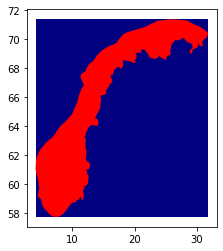

In [11]:
"""Here we are visualizing the spatial index of the country as a test"""
"""
SELECT ST_AsEWKT(ST_MakeEnvelope (
    4.087524332196379, 57.75900528198801, --lng-lat bounding 
    31.761592895114386, 71.38487875561317, --lng-lat box limits (Example)
    4326))
"""
#this polygon is from the spatial index of the linestring, the idea is to see what does it have
polygon_test = Polygon([(4.08752433219638, 57.759005281988),(4.08752433219638, 71.3848787556132),(31.7615928951144, 71.3848787556132),(31.7615928951144, 57.759005281988),(4.08752433219638, 57.759005281988)])

fig, ax = plt.subplots(1)
test_gdf = gpd.GeoSeries(polygon_test)
test_gdf.plot(ax=ax, cmap = 'jet')
client_dissolve.plot(ax=ax, color='red')
#this is not okay, the spatial index is way too big